### Universidad del Valle de Guatemala<br>Data Science<br>Laboratorio6<br>

#### Integrantes:<br>- Christopher García 20541<br>- Andrea Lam 20102

In [3]:
# Importar las bibliotecas necesarias
%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

### Se accede a Kaggle para obtener datos

In [2]:
!pip install kaggle

In [3]:
import os

# Obtener el directorio actual donde se encuentra el archivo de Jupyter Notebook
current_directory = os.path.dirname(os.path.abspath('__file__'))

# Ruta completa al directorio .kaggle en el directorio actual
kaggle_directory = os.path.join(current_directory, ".kaggle")

# Crear el directorio .kaggle si no existe
if not os.path.exists(kaggle_directory):
    os.mkdir(kaggle_directory)


In [4]:
!copy .kaggle\kaggle.json %userprofile%\.kaggle\

        1 file(s) copied.


In [5]:
! chmod 600 ~/.kaggle/kaggle.json

'chmod' is not recognized as an internal or external command,
operable program or batch file.


In [6]:
!kaggle datasets download -d jessicali9530/celeba-dataset

celeba-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [7]:
import os
import zipfile


# Obtener la ubicación actual de trabajo
current_directory = os.getcwd()

# Definir una ubicación para la extracción
extract_path = os.path.join(current_directory, "celeba-dataset")

# Crear la carpeta de extracción si no existe
if not os.path.exists(extract_path):
    os.makedirs(extract_path)

# Extraer el archivo ZIP
zip_ref = zipfile.ZipFile('celeba-dataset.zip', 'r')
zip_ref.extractall(extract_path)
zip_ref.close()


In [23]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Redimensiona las imágenes a 128x128 píxeles
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


## Preparacion de datos

In [12]:
# Define las variables
ngpu = 1
ngf = 64
nc = 3
nz = 100
lr = 0.0002
beta1 = 0.5
batch_size = 128
num_epochs = 5
workers = 2
ndf = 64
image_size = 64

In [10]:
# Especifica la ruta al directorio de datos
data_dir = 'celeba-dataset/img_align_celeba/'

# Define la transformación para preprocesar las imágenes
dataset = dset.ImageFolder(root=data_dir,
                            transform=transforms.Compose([
                                transforms.Resize(image_size),          # Redimensionar la imagen
                                transforms.CenterCrop(image_size),      # Recortar al centro
                                transforms.ToTensor(),                  # Convertir la imagen a un tensor
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # Normalizar
                            ]))

# Crea un DataLoader para facilitar el acceso a los datos en lotes
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                            shuffle=True, num_workers=workers)

# Define el dispositivo (CPU o GPU)
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")


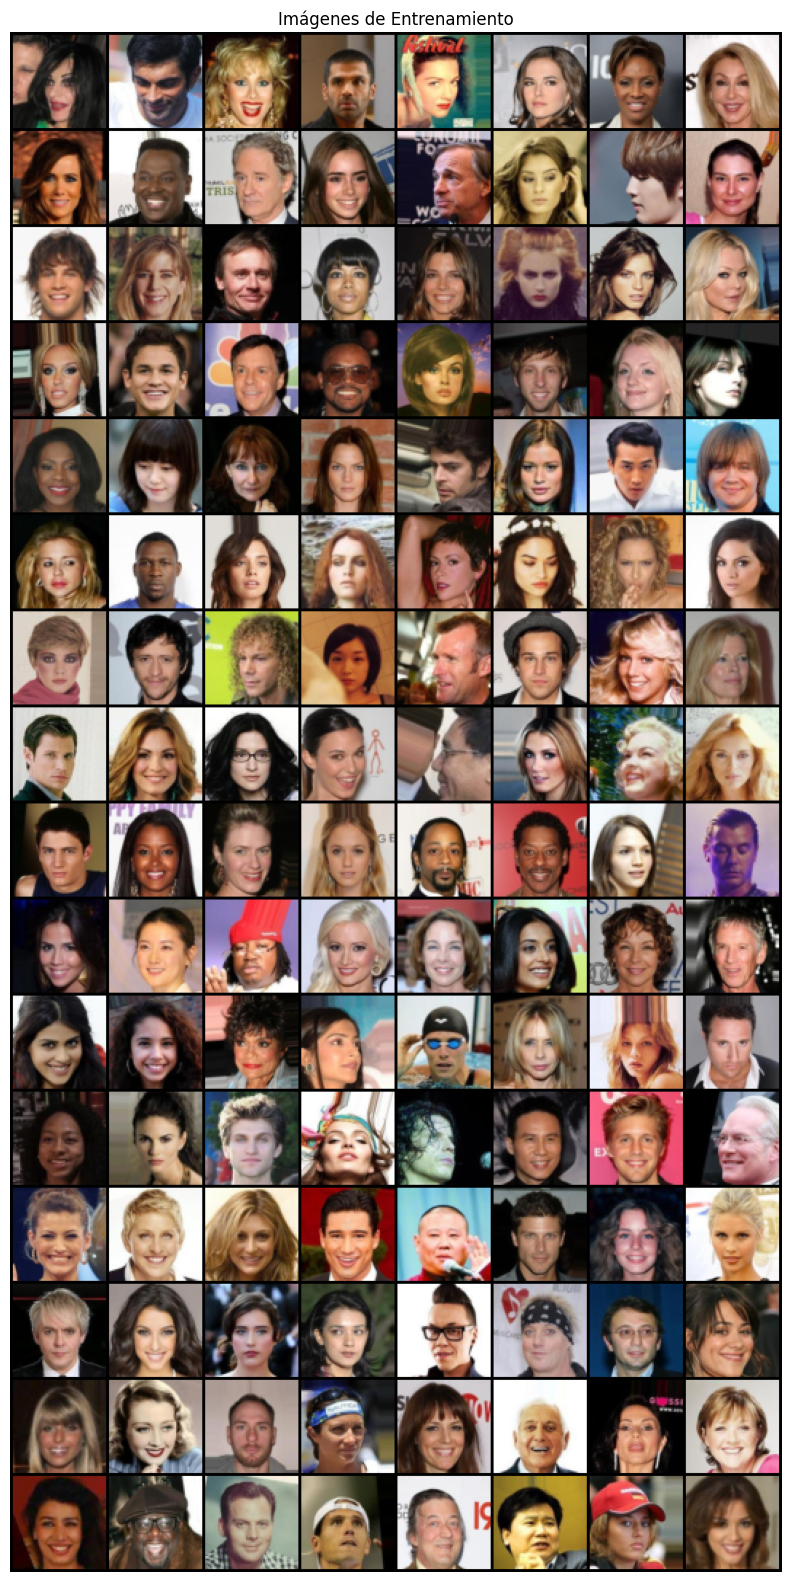

In [14]:
import torchvision.utils as vutils
real_batch = next(iter(dataloader))
plt.figure(figsize=(20, 20))
plt.axis("off")
plt.title("Imágenes de Entrenamiento")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:128], padding=2, normalize=True).cpu(), (1, 2, 0)))

# Redimensionar imagenes

In [1]:
def weights_init(m):
    # Obtiene el nombre de la clase del módulo
    classname = m.__class__.__name__
    
    # Si el módulo es una capa convolucional
    if classname.find('Conv') != -1:
        # Inicializa los pesos de la capa convolucional con una distribución normal centrada en 0 y una desviación estándar de 0.02
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        
    # Si el módulo es una capa de normalización por lotes (Batch Normalization)
    elif classname.find('BatchNorm') != -1:
        # Inicializa los pesos de la capa de normalización por lotes con una distribución normal centrada en 1 y una desviación estándar de 0.02
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        
        # Inicializa el sesgo (bias) de la capa de normalización por lotes a 0
        nn.init.constant_(m.bias.data, 0)

## Implementacion de la GAN

In [4]:
# Código del Generador

# Definir la clase del Generador, que hereda de nn.Module (la clase base para todos los módulos de red neuronal en PyTorch)
class Generator(nn.Module):
    # Constructor de la clase
    def __init__(self, ngpu):
        # Llamar al constructor de la clase padre (nn.Module)
        super(Generator, self).__init__()
        
        # Guardar el número de GPUs disponibles
        self.ngpu = ngpu
        
        # Definir la arquitectura del generador como una secuencia de capas
        self.main = nn.Sequential(
            # La entrada es el vector latente Z, que se transforma mediante una convolución transpuesta
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # Tamaño del estado: (ngf*8) x 4 x 4
            
            # Añadir más capas para aumentar la resolución y complejidad de la imagen
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # Tamaño del estado: (ngf*4) x 8 x 8
            
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # Tamaño del estado: (ngf*2) x 16 x 16
            
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # Tamaño del estado: (ngf) x 32 x 32
            
            # La última capa produce una imagen a color (nc canales) con resolución 64x64
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # Tamaño del estado: (nc) x 64 x 64
        )

    # Definir la operación de avance (forward) para el generador
    def forward(self, input):
        return self.main(input)

In [5]:
# Definir la clase del Discriminador, que también hereda de nn.Module
class Discriminator(nn.Module):
    # Constructor de la clase
    def __init__(self, ngpu):
        # Llamar al constructor de la clase padre (nn.Module)
        super(Discriminator, self).__init__()
        
        # Guardar el número de GPUs disponibles
        self.ngpu = ngpu
        
        # Definir la arquitectura del discriminador como una secuencia de capas
        self.main = nn.Sequential(
            # La entrada es una imagen con canales nc y tamaño 64x64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # Tamaño del estado: (ndf) x 32 x 32
            
            # Añadir más capas para reducir progresivamente la resolución de la imagen
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # Tamaño del estado: (ndf*2) x 16 x 16
            
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # Tamaño del estado: (ndf*4) x 8 x 8
            
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # Tamaño del estado: (ndf*8) x 4 x 4
            
            # La última capa reduce todo a una única salida: la probabilidad de que la imagen sea real
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    # Definir la operación de avance (forward) para el discriminador
    def forward(self, input):
        return self.main(input)

**# Definicion perdida y optimizadores**

In [13]:
# Define el generador y el discriminador

# Crear el generador
netG = Generator(ngpu).to(device)
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

netG.apply(weights_init)
print(netG)

# Crear el Discriminador
netD = Discriminator(ngpu).to(device)
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))
    
netD.apply(weights_init)
print(netD)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


**Inicializar perdida**

In [14]:

criterion = nn.BCELoss()
fixed_noise = torch.randn(64, nz, 1, 1, device=device)
real_label = 1
fake_label = 0
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

## Entrenamiento de la GAN

In [33]:
real_labels = torch.ones((batch_size, 1, 1, 1), device=device)
fake_labels = torch.zeros((batch_size, 1, 1, 1), device=device)

In [15]:
# Bucle de entrenamiento

# Listas para hacer seguimiento del progreso
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Iniciando bucle de entrenamiento...")
# Para cada época
for epoch in range(num_epochs):
    # Para cada lote en el dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Actualizar la red D: maximizar log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Entrenar con lote completamente real
        netD.zero_grad()
        # Formatear el lote
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Pasada hacia adelante del lote real a través de D
        output = netD(real_cpu).view(-1)
        # Calcular la pérdida en el lote completamente real
        errD_real = criterion(output, label)
        # Calcular los gradientes para D en la pasada hacia atrás
        errD_real.backward()
        D_x = output.mean().item()

        ## Entrenar con lote completamente falso
        # Generar lote de vectores latentes
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generar lote de imágenes falsas con G
        fake = netG(noise)
        label.fill_(fake_label)
        # Clasificar todo el lote falso con D
        output = netD(fake.detach()).view(-1)
        # Calcular la pérdida de D en el lote completamente falso
        errD_fake = criterion(output, label)
        # Calcular los gradientes para este lote
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Sumar los gradientes de los lotes completamente reales y falsos
        errD = errD_real + errD_fake
        # Actualizar D
        optimizerD.step()

        ############################
        # (2) Actualizar la red G: maximizar log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # las etiquetas falsas son reales para el costo del generador
        # Como acabamos de actualizar D, realizamos otra pasada hacia adelante del lote completamente falso a través de D
        output = netD(fake).view(-1)
        # Calcular la pérdida de G en base a esta salida
        errG = criterion(output, label)
        # Calcular los gradientes para G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Actualizar G
        optimizerG.step()

        # Mostrar estadísticas del entrenamiento
        if i % 10 == 0:  # Cambiado de 1000 a 10 para actualizaciones más frecuentes
            print('[%d/%d][%d/%d]\tPérdida_D: %.4f\tPérdida_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                % (epoch, num_epochs, i, len(dataloader),
                    errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Guardar las pérdidas para graficar más tarde
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Verificar cómo va el generador guardando la salida de G en fixed_noise
        if (iters % 250 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Iniciando bucle de entrenamiento...
[0/5][0/1489]	Pérdida_D: 1.7270	Pérdida_G: 4.2348	D(x): 0.4576	D(G(z)): 0.5010 / 0.0217
[0/5][10/1489]	Pérdida_D: 0.2828	Pérdida_G: 8.2982	D(x): 0.9242	D(G(z)): 0.0878 / 0.0004
[0/5][20/1489]	Pérdida_D: 0.1092	Pérdida_G: 14.8977	D(x): 0.9368	D(G(z)): 0.0003 / 0.0000
[0/5][30/1489]	Pérdida_D: 2.1317	Pérdida_G: 23.7632	D(x): 0.9394	D(G(z)): 0.7997 / 0.0000
[0/5][40/1489]	Pérdida_D: 0.2229	Pérdida_G: 12.7547	D(x): 0.9276	D(G(z)): 0.0001 / 0.0000
[0/5][50/1489]	Pérdida_D: 0.0386	Pérdida_G: 6.3795	D(x): 0.9832	D(G(z)): 0.0142 / 0.0085
[0/5][60/1489]	Pérdida_D: 0.4058	Pérdida_G: 22.4033	D(x): 0.8523	D(G(z)): 0.0000 / 0.0000
[0/5][70/1489]	Pérdida_D: 0.4143	Pérdida_G: 29.3707	D(x): 0.8260	D(G(z)): 0.0000 / 0.0000
[0/5][80/1489]	Pérdida_D: 0.4018	Pérdida_G: 21.4298	D(x): 0.7932	D(G(z)): 0.0000 / 0.0000
[0/5][90/1489]	Pérdida_D: 0.1585	Pérdida_G: 5.9774	D(x): 0.9230	D(G(z)): 0.0087 / 0.0139
[0/5][100/1489]	Pérdida_D: 1.7462	Pérdida_G: 17.4856	D(x): 0.4710	D(G

# Graficas

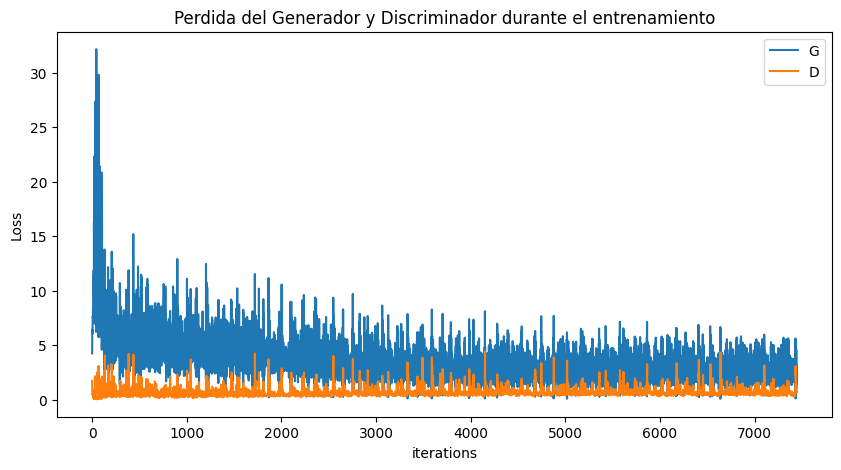

In [16]:
plt.figure(figsize=(10,5))
plt.title("Perdida del Generador y Discriminador durante el entrenamiento")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

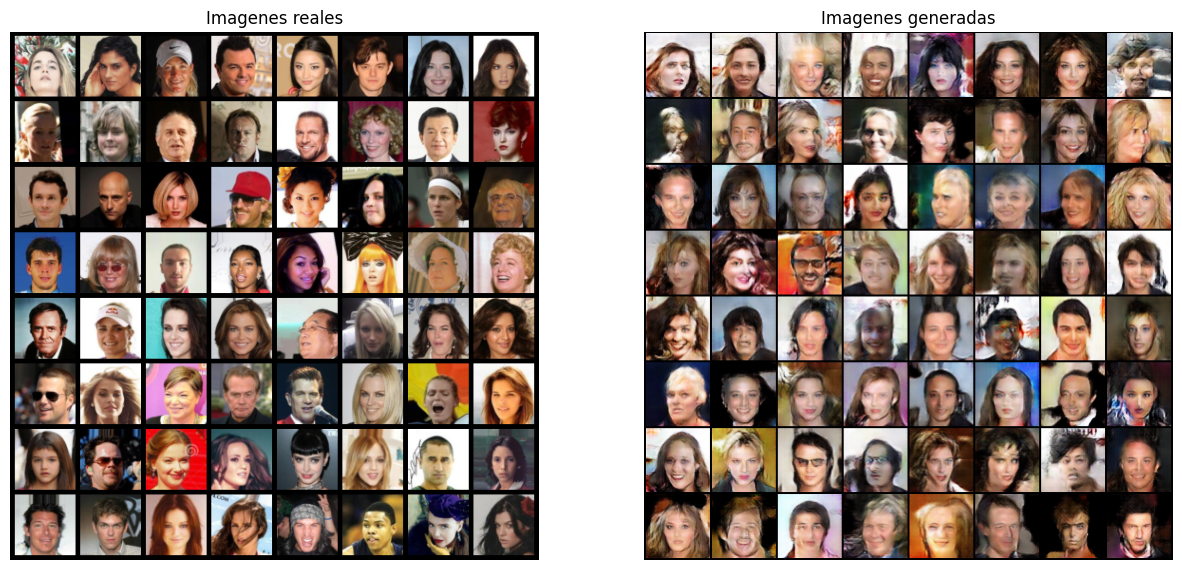

In [17]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Imagenes reales")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Imagenes generadas")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

# Reflexion

1. ¿Qué conceptos de la teoría encontraron más desafiantes y por qué?
- Generadores y discriminadores: Comprender el funcionamiento de dos redes neurales adversarias, el generador y el discriminador, y cómo interactúan entre sí puede ser un desafío inicial.
- Pérdida adversaria: Entender cómo funciona la pérdida adversaria y cómo se utiliza para entrenar a ambas redes de manera competitiva.
- Problemas de convergencia: GANs pueden ser difíciles de entrenar y pueden no converger fácilmente.

2. ¿Cómo les ayudó el laboratorio a consolidar o entender mejor estos conceptos?
- A través de la implementación práctica de una GAN, se puede ver en la práctica cómo funcionan los generadores y discriminadores, cómo se definen las pérdidas y cómo se entrena el modelo.
- Experimentar con diferentes hiperparámetros y ajustar el modelo puede ayudar a comprender cómo afectan estos cambios al rendimiento de la GAN.

3. ¿Qué aplicaciones potenciales ven para las GANs en la industria o en la investigación?
- Generación de imágenes realistas.
- Mejora y restauración de imágenes.
- Transferencia de estilo y generación de arte.
- Generación de texto y lenguaje natural.
- Simulación y generación de datos sintéticos.
- Anonimización de datos y privacidad.
- Mejora de la realidad virtual y aumentada.

4. ¿Qué limitaciones o preocupaciones éticas pueden identificar en el uso de GANs?
- Generación de contenido falso: Las GANs pueden utilizarse para crear imágenes y videos falsos, lo que plantea preocupaciones sobre la desinformación y la manipulación.
- Privacidad: Las GANs pueden utilizarse para crear imágenes realistas de personas inexistentes, lo que plantea preocupaciones éticas en términos de privacidad y consentimiento.
- Sesgos: Si los datos de entrenamiento contienen sesgos, las GANs pueden aprender y amplificar esos sesgos en las generaciones.

5. ¿Cómo se sienten con respecto a la implementación y entrenamiento de GANs después de la
experiencia práctica?

Primeramente no se esperaba que fuera tan pesado el entrenamiento, pero al tener en cuenta ascpectos como aprender de rostros y crearlos, tiene sentido.
Seguidamente esta practica ayudo mucho en el entendimiento de la importancia de redimensionar y los pesos de las imagenes, al mismo tiempo que buscar minimizar el sobre ajuste.